In [1]:
from sklearn import model_selection, datasets, linear_model, metrics
from matplotlib.colors import ListedColormap
import matplotlib as plt

from json import dump
import numpy as np
import random as rnd

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/pd/opt/anaconda3/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


# **Генерируем множество точек**

In [3]:
blobs = datasets.make_blobs(centers = 2, cluster_std = 5.5, random_state=10)
x_coordinates = [int(x[0]) for x in blobs[0]]
y_coordinates = [int(x[1]) for x in blobs[0]]

# **Объявляем класс генетического алгоритма**

In [4]:
class GA:
    def __init__(self, estimator, bounds=None, dimension=None, steps_number=100, accuracy=None, stagnation=None,
                 population_size=20, survive_part=0.25, productivity=4, crossover_type="split",
                 number_of_mutated_individuals=1, mutation_type="one_step", filename="final_population.json"):
        self.estimator = estimator
        self.steps_number = steps_number
        self.accuracy = accuracy
        self.stagnation = stagnation
        self.population_size = population_size
        self.survive_part = survive_part
        self.productivity = productivity
        self.crossover_type = crossover_type
        self.number_of_mutated_individuals = number_of_mutated_individuals
        self.mutation_type = mutation_type
        self.filename = filename
        self.best = [] 
        default_step = 0.01
        default_bounds = (-100, 100)
        self.best_ever = None
        if type(bounds) is list:
            self.bounds = bounds
        elif type(bounds) is tuple and dimension:
            try:
                self.bounds = [(bounds[0], bounds[1], bounds[2])] * dimension
            except IndexError:
                self.bounds = [(bounds[0], bounds[1], default_step)] * dimension
        elif not bounds:
            self.bounds = [(default_bounds[0], default_bounds[1], default_step)] * dimension

    def fit(self, steps=None, new_individuals=None):
        if steps:
            self.steps_number = steps
        if type(new_individuals) != list:
            new_individuals = []
        self.best_ever = None
        for i in range(self.steps_number):
            population = self.generate_population(new_individuals)
            survivors = self.survive(population)
            new_individuals = self.crossover(survivors)
            self.best.append(survivors[0])
            if not self.best_ever:
                self.best_ever = self.best[-1]
            else:
                self.best_ever = max(self.best_ever, self.best[-1], key=lambda i: i[1])
            if self.filename:
                dump(new_individuals, open(self.filename, "w"), separators=(",", ":"))
            if self.stagnation:
                best_fitness = [i[1] for i in self.best[-self.stagnation:]]
                if len(best_fitness) == self.stagnation and len(set(best_fitness)) == 1:
                    new_individuals = self.cataclysm(population)
        return self.best_ever

    def generate_population(self, new_individuals):
        population = []
        for individual in new_individuals:
            individual = self.mutate(individual, self.mutation_type, self.number_of_mutated_individuals)
            fitness = self.estimator(individual)
            population.append((individual, fitness))
        for _ in range(self.population_size - len(new_individuals)):
            individual = []
            if "random" in self.mutation_type or "change" in self.mutation_type:
                for bounds in self.bounds:
                    gene = rnd.uniform(bounds[0], bounds[1])
                    individual.append(gene)
            elif "step" in self.mutation_type:
                for bounds in self.bounds:
                    step = bounds[2]
                    gene = rnd.choice(possible_genes(bounds[0], bounds[1] + step, step))
                    individual.append(gene)
            fitness = self.estimator(individual)
            population.append((individual, fitness))
            new_individuals.append(individual)
        return population

    def survive(self, population):
        num_survivors = int(self.population_size * self.survive_part)
        best = sorted(population, key=lambda i: -i[1])[:num_survivors]
        return best

    def crossover(self, best):
        new_individuals = []
        for _ in range(len(best) * self.productivity):
            dad, mom = rnd.sample(best, 2)
            dad, mom = dad[0], mom[0]
            child = []
            if self.crossover_type == "random":
                for gene_m, gene_f in zip(dad, mom):
                    gene = rnd.choice((gene_m, gene_f))
                    child.append(gene)
            elif self.crossover_type == "split":
                split = len(dad) // 2
                child = dad[:split] + mom[split:]
            new_individuals.append(child)
        return new_individuals

    def mutate(self, individual, mutagen, mutate_genes=None):
        if mutagen == "one_random":
            gene_ids = [rnd.randint(0, len(individual) - 1) for _ in range(mutate_genes)]
            for gene_id in gene_ids:
                gene_id = rnd.randint(0, len(individual) - 1)
                individual[gene_id] = rnd.uniform(self.bounds[gene_id][0], self.bounds[gene_id][1])
        elif mutagen == "full_random":
            for gene_id in range(len(individual)):
                individual[gene_id] = rnd.uniform(self.bounds[gene_id][0], self.bounds[gene_id][1])
        elif mutagen == "one_change":
            gene_ids = [rnd.randint(0, len(individual) - 1) for _ in range(mutate_genes)]
            for gene_id in gene_ids:
                while True:
                    coef = rnd.uniform(0.9, 1.1)
                    if self.bounds[gene_id][0] <= individual[gene_id] * coef <= self.bounds[gene_id][1]:
                        individual[gene_id] *= coef
                        break
        elif mutagen == "full_change":
            for gene_id in range(len(individual)):
                while True:
                    coef = rnd.uniform(0.9, 1.1)
                    if self.bounds[gene_id][0] <= individual[gene_id] * coef <= self.bounds[gene_id][1]:
                        individual[gene_id] *= coef
                        break
        elif mutagen == "one_step":
            gene_ids = [rnd.randint(0, len(individual) - 1) for _ in range(mutate_genes)]
            for gene_id in gene_ids:
                gene_id = rnd.randint(0, len(individual) - 1)
                while True:
                    step = self.bounds[gene_id][2]
                    step = rnd.choice([-step, step])
                    if self.bounds[gene_id][0] <= individual[gene_id] + step <= self.bounds[gene_id][1]:
                        individual[gene_id] += step
                        break
        elif mutagen == "full_step":
            for gene_id in range(len(individual)):
                while True:
                    step = self.bounds[gene_id][2]
                    step = rnd.choice([-step, step])
                    if self.bounds[gene_id][0] <= individual[gene_id] + step <= self.bounds[gene_id][1]:
                        individual[gene_id] += step
                        break
        return individual

    def cataclysm(self, population):
        post_population = []
        for individual, _fitness in population:
            post_population.append(self.mutate(individual, self.mutation_type, self.number_of_mutated_individuals))
        return post_population


def possible_genes(start, stop, step):
    genes = []
    while start < stop:
        genes.append(start)
        start += step
    return genes

# **Функция среднеквадратичной ошибки**

In [5]:
def MSE(x):
    error = 0
    for i in range(len(x_coordinates)):
        error += (x[0] * x_coordinates[i] + x[1] - y_coordinates[i]) ** 2
    return -abs(error)

In [6]:
ga = GA(MSE, bounds=(-100, 100, 1), dimension=2, steps_number=1000, accuracy=0, stagnation=3,
            population_size=10, survive_part=0.2, productivity=4, mutation_type="full_random")
result = ga.fit()
solution = []
solution.append(result[0])
solution.append(np.sqrt(-result[1]))
print("Solution:", solution)

Solution: [[0.12057085454948435, -3.288044682806742], 87.45397099829587]


# **Строим множество точек из двух классов и разделяющую их прямую**

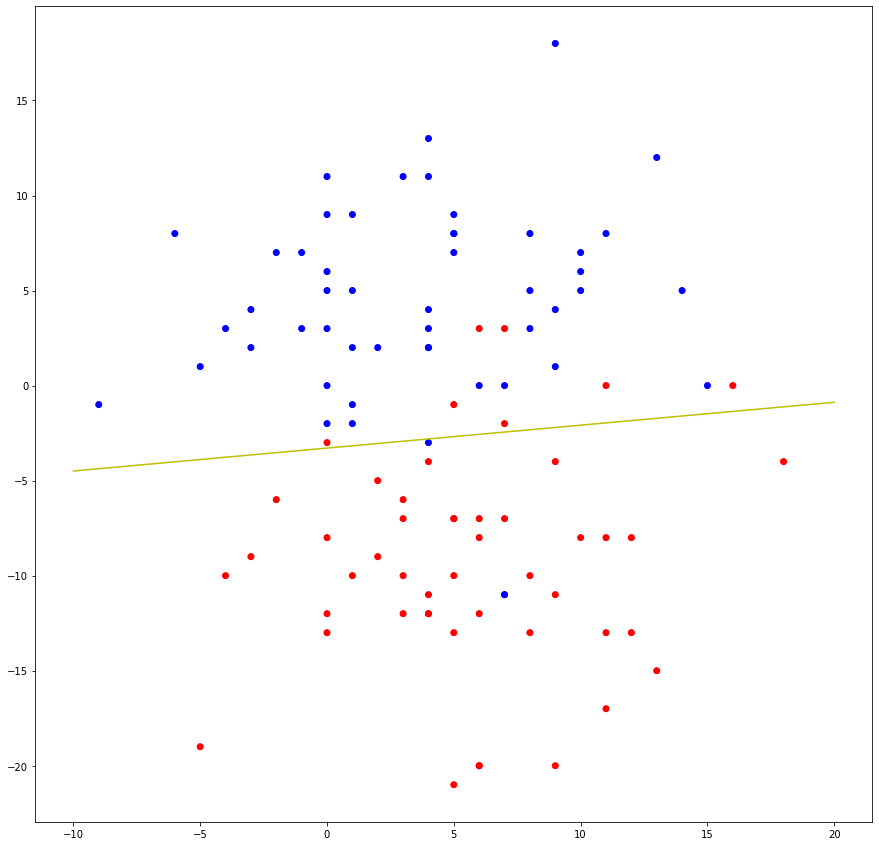

In [7]:
colors = ListedColormap(['red', 'blue'])
pylab.figure(figsize(15, 15))
pylab.scatter(x_coordinates, y_coordinates, c=blobs[1], cmap=colors)
x = np.linspace(-10,20,100)
y = solution[0][0]*x+solution[0][1]
pylab.plot(x,y,'-y')